# YOLO Label Checker

This notebook visualizes existing YOLO format labels to verify them before uploading to Roboflow.

In [8]:
# Import required libraries
import os
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, clear_output
import ipywidgets as widgets

# Import config
try:
    from config_template import INPUT_DIR, OUTPUT_DIR
    # Convert to absolute paths from project root
    project_root = Path(__file__).resolve().parents[4]  # Go up to project root
    INPUT_DIR = str(project_root / INPUT_DIR)
    OUTPUT_DIR = str(project_root / OUTPUT_DIR)
except:
    # If running in notebook, use absolute paths
    INPUT_DIR = "/Users/marcelmerkx/Development/universal-scanner/data/OCR/cutouts"
    OUTPUT_DIR = "/Users/marcelmerkx/Development/universal-scanner/data/OCR/labels"

print(f"Images directory: {INPUT_DIR}")
print(f"Labels directory: {OUTPUT_DIR}")

# Verify directories exist
if os.path.exists(INPUT_DIR):
    print(f"✓ Images directory exists with {len(os.listdir(INPUT_DIR))} files")
else:
    print(f"✗ Images directory not found!")
    
if os.path.exists(OUTPUT_DIR):
    print(f"✓ Labels directory exists with {len(os.listdir(OUTPUT_DIR))} files")
else:
    print(f"✗ Labels directory not found!")

Images directory: /Users/marcelmerkx/Development/universal-scanner/data/OCR/cutouts
Labels directory: /Users/marcelmerkx/Development/universal-scanner/data/OCR/labels
✓ Images directory exists with 2077 files
✓ Labels directory exists with 11 files


In [ ]:
class YOLOLabelVisualizer:
    def __init__(self, images_dir, labels_dir):
        """Initialize the YOLO label visualizer"""
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        
        # Get all image files that have corresponding labels
        self.image_label_pairs = self._get_image_label_pairs()
        self.current_index = 0
        
        print(f"Found {len(self.image_label_pairs)} images with labels")
        
    def _get_image_label_pairs(self):
        """Get all image files that have corresponding label files"""
        extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        pairs = []
        
        # Get all label files
        label_files = list(self.labels_dir.glob("*.txt"))
        
        for label_file in sorted(label_files):
            # Skip non-label files
            if label_file.suffix != '.txt':
                continue
                
            # Look for corresponding image
            base_name = label_file.stem
            image_file = None
            
            for ext in extensions:
                potential_image = self.images_dir / f"{base_name}{ext}"
                if potential_image.exists():
                    image_file = potential_image
                    break
                # Try uppercase extension
                potential_image = self.images_dir / f"{base_name}{ext.upper()}"
                if potential_image.exists():
                    image_file = potential_image
                    break
            
            if image_file:
                pairs.append((image_file, label_file))
            else:
                print(f"Warning: No image found for label {label_file.name}")
        
        return pairs
    
    def read_yolo_labels(self, label_path):
        """Read YOLO format labels from file"""
        boxes = []
        
        try:
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])
                        
                        boxes.append({
                            'class_id': class_id,
                            'x_center': x_center,
                            'y_center': y_center,
                            'width': width,
                            'height': height
                        })
        except Exception as e:
            print(f"Error reading label file {label_path}: {e}")
        
        return boxes
    
    def yolo_to_xyxy(self, box, img_width, img_height):
        """Convert YOLO format to xyxy format"""
        x_center = box['x_center'] * img_width
        y_center = box['y_center'] * img_height
        width = box['width'] * img_width
        height = box['height'] * img_height
        
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2
        
        return x1, y1, x2, y2
    
    def visualize_image(self, index):
        """Visualize a single image with its labels"""
        if index < 0 or index >= len(self.image_label_pairs):
            print(f"Invalid index: {index}")
            return None
            
        image_path, label_path = self.image_label_pairs[index]
        
        # Read image
        image = cv2.imread(str(image_path))
        if image is None:
            print(f"Error reading image: {image_path}")
            return None
            
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        # Read labels
        boxes = self.read_yolo_labels(label_path)
        
        # Create figure
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(image_rgb)
        
        # Draw boxes
        colors = plt.cm.rainbow(np.linspace(0, 1, max(1, len(boxes))))
        
        for i, (box, color) in enumerate(zip(boxes, colors)):
            x1, y1, x2, y2 = self.yolo_to_xyxy(box, w, h)
            
            # Create rectangle
            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)
            
            # Add box number
            ax.text(
                x1, y1 - 5, f'Box {i+1}',
                color=color, fontsize=10, weight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
            )
        
        # Set title and remove axes
        ax.set_title(f"Image: {image_path.name} | Boxes: {len(boxes)} | Index: {index + 1}/{len(self.image_label_pairs)}")
        ax.axis('off')
        
        plt.tight_layout()
        return fig
    
    def create_interactive_viewer(self):
        """Create interactive widgets for viewing images"""
        if len(self.image_label_pairs) == 0:
            print("No images with labels found!")
            return widgets.VBox([widgets.Label(value="No labeled images to display")])
            
        # Create widgets
        self.index_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=len(self.image_label_pairs) - 1,
            step=1,
            description='Image:',
            continuous_update=False
        )
        
        self.prev_button = widgets.Button(description='Previous')
        self.next_button = widgets.Button(description='Next')
        
        self.info_label = widgets.Label(value='')
        
        self.output = widgets.Output()
        
        # Button callbacks
        def on_prev_clicked(b):
            if self.index_slider.value > 0:
                self.index_slider.value -= 1
                
        def on_next_clicked(b):
            if self.index_slider.value < len(self.image_label_pairs) - 1:
                self.index_slider.value += 1
                
        self.prev_button.on_click(on_prev_clicked)
        self.next_button.on_click(on_next_clicked)
        
        # Flag to prevent multiple updates
        self._updating = False
        
        # Update function
        def update_display(change=None):
            if self._updating:
                return
                
            self._updating = True
            
            with self.output:
                clear_output(wait=True)
                
                # Update info label
                image_path, label_path = self.image_label_pairs[self.index_slider.value]
                boxes = self.read_yolo_labels(label_path)
                self.info_label.value = f"Label file: {label_path.name} | Boxes: {len(boxes)}"
                
                # Visualize
                fig = self.visualize_image(self.index_slider.value)
                if fig:
                    plt.show()
                    plt.close(fig)
            
            self._updating = False
        
        # Observe changes
        self.index_slider.observe(update_display, names='value')
        
        # Create layout
        controls = widgets.HBox([
            self.prev_button,
            self.index_slider,
            self.next_button
        ])
        
        viewer = widgets.VBox([controls, self.info_label, self.output])
        
        # Initial display
        update_display()
        
        return viewer
    
    def create_grid_viewer(self, images_per_page=3):
        """Create a grid viewer showing multiple images per page"""
        if len(self.image_label_pairs) == 0:
            print("No images with labels found!")
            return widgets.VBox([widgets.Label(value="No labeled images to display")])
        
        # Calculate pages
        total_pages = (len(self.image_label_pairs) + images_per_page - 1) // images_per_page
        
        # Create widgets
        self.page_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=total_pages - 1,
            step=1,
            description='Page:',
            continuous_update=False
        )
        
        self.prev_button = widgets.Button(description='Previous Page')
        self.next_button = widgets.Button(description='Next Page')
        
        self.output = widgets.Output()
        
        # Button callbacks
        def on_prev_clicked(b):
            if self.page_slider.value > 0:
                self.page_slider.value -= 1
                
        def on_next_clicked(b):
            if self.page_slider.value < total_pages - 1:
                self.page_slider.value += 1
                
        self.prev_button.on_click(on_prev_clicked)
        self.next_button.on_click(on_next_clicked)
        
        # Update function
        def update_grid_display(change=None):
            with self.output:
                clear_output(wait=True)
                
                # Calculate indices for current page
                start_idx = self.page_slider.value * images_per_page
                end_idx = min(start_idx + images_per_page, len(self.image_label_pairs))
                
                # Create grid layout
                n_images = end_idx - start_idx
                fig, axes = plt.subplots(1, n_images, figsize=(6 * n_images, 6))
                if n_images == 1:
                    axes = [axes]
                
                for i, ax in enumerate(axes):
                    idx = start_idx + i
                    if idx < len(self.image_label_pairs):
                        image_path, label_path = self.image_label_pairs[idx]
                        
                        # Read image
                        image = cv2.imread(str(image_path))
                        if image is not None:
                            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                            h, w = image.shape[:2]
                            
                            # Read labels
                            boxes = self.read_yolo_labels(label_path)
                            
                            # Display image
                            ax.imshow(image_rgb)
                            
                            # Draw boxes
                            colors = plt.cm.rainbow(np.linspace(0, 1, max(1, len(boxes))))
                            for j, (box, color) in enumerate(zip(boxes, colors)):
                                x1, y1, x2, y2 = self.yolo_to_xyxy(box, w, h)
                                rect = patches.Rectangle(
                                    (x1, y1), x2 - x1, y2 - y1,
                                    linewidth=2, edgecolor=color, facecolor='none'
                                )
                                ax.add_patch(rect)
                            
                            ax.set_title(f"{image_path.name}\n{len(boxes)} boxes", fontsize=10)
                            ax.axis('off')
                
                plt.suptitle(f"Page {self.page_slider.value + 1}/{total_pages}", fontsize=14)
                plt.tight_layout()
                plt.show()
        
        # Observe changes
        self.page_slider.observe(update_grid_display, names='value')
        
        # Create layout
        controls = widgets.HBox([
            self.prev_button,
            self.page_slider,
            self.next_button
        ])
        
        viewer = widgets.VBox([controls, self.output])
        
        # Initial display
        update_grid_display()
        
        return viewer

In [10]:
# Initialize the visualizer
visualizer = YOLOLabelVisualizer(
    images_dir=INPUT_DIR,
    labels_dir=OUTPUT_DIR
)

DEBUG: Found 10 .txt files in labels directory
DEBUG: Matched AMFU3211042.txt -> AMFU3211042.jpg
DEBUG: Matched AMFU8908955.txt -> AMFU8908955.jpg
DEBUG: Matched AMFU8950723.txt -> AMFU8950723.jpg
DEBUG: Matched APHU6377338.txt -> APHU6377338.jpg
DEBUG: Matched APHU6432306.txt -> APHU6432306.jpg
DEBUG: Matched APHU6562110.txt -> APHU6562110.jpg
DEBUG: Matched APHU6686445.txt -> APHU6686445.jpg
DEBUG: Matched APHU6774593.txt -> APHU6774593.jpg
DEBUG: Matched APHU6831076.txt -> APHU6831076.jpg
DEBUG: Matched APZU3160824.txt -> APZU3160824.jpg
Found 10 images with labels


In [19]:
# Create and display the interactive viewer
# Option 1: Single image view
viewer = visualizer.create_interactive_viewer()
display(viewer)

## Label Statistics

Run the cell below to see statistics about the labels.

=== Label Statistics ===
Total labeled images: 10
Total boxes: 73
Average boxes per image: 7.30
Min boxes: 4
Max boxes: 11
Std deviation: 1.79


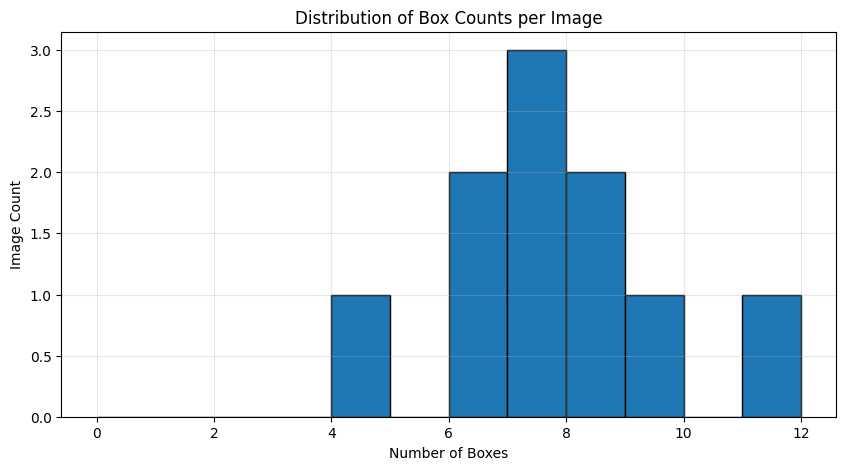

In [18]:
# Analyze label statistics
def analyze_labels(visualizer):
    """Analyze statistics across all label files"""
    box_counts = []
    total_boxes = 0
    
    for image_path, label_path in visualizer.image_label_pairs:
        boxes = visualizer.read_yolo_labels(label_path)
        box_counts.append(len(boxes))
        total_boxes += len(boxes)
    
    if not box_counts:
        print("No labels found!")
        return
    
    # Print statistics
    print("=== Label Statistics ===")
    print(f"Total labeled images: {len(box_counts)}")
    print(f"Total boxes: {total_boxes}")
    print(f"Average boxes per image: {np.mean(box_counts):.2f}")
    print(f"Min boxes: {min(box_counts)}")
    print(f"Max boxes: {max(box_counts)}")
    print(f"Std deviation: {np.std(box_counts):.2f}")
    
    # Images with no boxes
    empty_images = sum(1 for c in box_counts if c == 0)
    if empty_images > 0:
        print(f"\nWarning: {empty_images} images have no boxes!")
    
    # Plot distribution
    plt.figure(figsize=(10, 5))
    plt.hist(box_counts, bins=range(0, max(box_counts) + 2), edgecolor='black')
    plt.xlabel('Number of Boxes')
    plt.ylabel('Image Count')
    plt.title('Distribution of Box Counts per Image')
    plt.grid(True, alpha=0.3)
    plt.show()

# Run analysis
analyze_labels(visualizer)

## Quick Check: Images Without Labels

This cell checks for any images in the cutouts directory that don't have corresponding labels.

In [ ]:
# Check for images without labels
def find_unlabeled_images(images_dir, labels_dir):
    """Find images that don't have corresponding label files"""
    images_dir = Path(images_dir)
    labels_dir = Path(labels_dir)
    
    extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    all_images = []
    
    for ext in extensions:
        all_images.extend(images_dir.glob(f"*{ext}"))
        all_images.extend(images_dir.glob(f"*{ext.upper()}"))
    
    unlabeled = []
    for image_path in all_images:
        label_path = labels_dir / f"{image_path.stem}.txt"
        if not label_path.exists():
            unlabeled.append(image_path)
    
    print(f"Total images: {len(all_images)}")
    print(f"Images without labels: {len(unlabeled)}")
    
    if unlabeled:
        print("\nUnlabeled images:")
        for img in sorted(unlabeled)[:10]:  # Show first 10
            print(f"  - {img.name}")
        if len(unlabeled) > 10:
            print(f"  ... and {len(unlabeled) - 10} more")
    
    return unlabeled

unlabeled_images = find_unlabeled_images(INPUT_DIR, OUTPUT_DIR)